In [ ]:
import pandas as pd
import numpy as np
import nltk
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # Added tqdm

import torch
from torch import nn
from torch.distributions import constraints
import functools

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList, AutoDelta
from pyro.optim import ClippedAdam

# Import from local modules
from preprocessing import preprocess_text, add_mask_column
from lda_model import model, create_guide


/opt/homebrew/Caskroom/miniconda/base/envs/bml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset
df = pd.read_csv("tmdb_5000_movies.csv")

# Remove rows with missing values in the 'overview' column
df.dropna(subset=['overview'], inplace=True)

In [3]:
# Apply to the DataFrame
df['processed'] = df['overview'].apply(preprocess_text)

# Create a dictionary and corpus for the processed text
dictionary = Dictionary(df['processed'])

# Map each list of tokens to a list of word indexes
df['overview_indexed'] = df['processed'].apply(lambda tokens: dictionary.doc2idx(tokens))

df['overview_length'] = df['overview_indexed'].apply(len)

df = df[df['overview_length'] >= 20]

# Create a mask column for the dataframe
df = add_mask_column(df, 'overview_indexed', length=60, new_column_name="overview_masked")


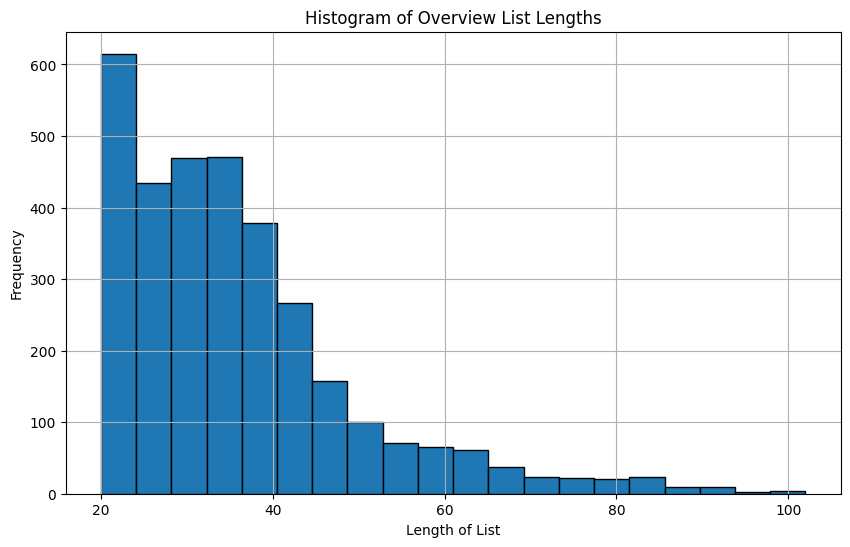

In [4]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['overview_length'], bins=20, edgecolor='black')
plt.title('Histogram of Overview List Lengths')
plt.xlabel('Length of List')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [5]:
W = df["overview_indexed"]
Mask = df["overview_masked"]

# Convert to a LongTensor (2D tensor)
tensor_W = torch.tensor(W.tolist(), dtype=torch.long).T
tensor_Mask = torch.tensor(Mask.tolist(), dtype=torch.bool).T

In [ ]:
from tqdm import tqdm
import torch.profiler # Added for profiling

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "mps" if torch.backends.mps.is_available() else device
print(f"Using device: {device}")

tensor_W = tensor_W.to(device)
tensor_Mask = tensor_Mask.to(device)

num_words = len(dictionary)
num_topics = 20
num_docs = 3236
num_words_per_doc = 60

pyro.clear_param_store()

guide = create_guide(model, num_topics, num_words, num_docs, device=device)

elbo = TraceEnum_ELBO(max_plate_nesting=3)

optim = ClippedAdam({'lr': 0.0001})
svi = SVI(lambda data, mask, batch_size: model(data, mask, batch_size, num_topics, num_words, num_docs, num_words_per_doc, device=device), guide, optim, elbo)

# Define the number of optimization steps
n_steps = 3000 # Reduced for profiling to get results faster, can be increased later

for step in tqdm(range(n_steps)):
    # with torch.profiler.record_function("svi_step_iteration"):
    elbo = svi.step(tensor_W, tensor_Mask, batch_size=16)
    if step % 100 == 0:
        tqdm.write(f"[{step}] ELBO: {elbo:.1f}")


Using device: cpu


  0%|          | 1/3000 [00:01<1:30:29,  1.81s/it]

[0] ELBO: 3441527.0


  3%|▎         | 101/3000 [01:05<30:14,  1.60it/s]

[100] ELBO: 3436375.5


  6%|▋         | 190/3000 [02:05<32:45,  1.43it/s]

In [11]:
print("CPU time total (all events):")
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=None))

print("\nCUDA time total (all events, if applicable):")
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=None))

CPU time total (all events):
-----------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    ProfilerStep*       100.00%       3.430ms       100.00%       3.430ms       3.430ms           0 b           0 b             1  
-----------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 3.430ms


CUDA time total (all events, if applicable):
-----------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  

In [ ]:
pyro.clear_param_store()

def my_local_guide(data=None, mask=None, batch_size=None):
    topic_words_posterior = pyro.param(
            "topic_words_posterior",
            lambda: torch.ones(num_topics, num_words),
            constraint=constraints.positive)

    with pyro.plate("topics", num_topics):
        pyro.sample("topic_words", dist.Dirichlet(topic_words_posterior))

    doc_topics_posterior = pyro.param(
            "doc_topics_posterior",
            lambda: torch.ones(num_docs, num_topics),
            constraint=constraints.simplex)

    with pyro.plate("documents", num_docs, batch_size) as ind:
        pyro.sample("doc_topics", dist.Delta(doc_topics_posterior[ind], event_dim=1))

    #beta_means = pyro.param(
    #        "beta_means",
    #        lambda: torch.zeros(num_docs, num_words),

    #beta = pyro.sample("beta", pyro.Normal(beta_means, 1))


guide = AutoGuideList(model)
guide.add(AutoDiagonalNormal(pyro.poutine.block(model, expose=['doc_topics']))) # We add the weights variables here
guide.add(my_local_guide)  # automatically wrapped in an AutoCallable

guide = my_local_guide

elbo = TraceEnum_ELBO(max_plate_nesting=3)

optim = ClippedAdam({'lr': 0.005})
svi = SVI(model, guide, optim, elbo)

# Define the number of optimization steps
n_steps = 2000

# do gradient steps
# Wrap range with tqdm for a progress bar
for step in tqdm(range(n_steps)):
    elbo = svi.step(tensor_W, tensor_Mask, batch_size=64)
    if step % 100 == 0:
        #print('.', end='')
        # Update print statement to work with tqdm
        tqdm.write(f"[{step}] ELBO: {elbo:.1f}")

In [ ]:
pyro.get_param_store().save("model_params.pyro")